# ***Image classification with zero shot learning***
This notebook shows the process and orientation in building an image classifier using deep learning and zero shot learning.

This notebook was created by: Leor Ariel Rose and Yahav Bar David.

## ***Import Libraries***

Before we begin let's import all the necessary libraries for this notebook.

In [1]:
import os
import numpy as np
import zipfile
import cv2
from matplotlib import pyplot as plt
from urllib import request
from tensorflow.keras.datasets import cifar100 as cifar100
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization,\
MaxPooling2D, Activation, Flatten
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Tuple

## ***Data Download and Loading***

For our zero shot learning we need to download fast text vectors from [***facebook pre-trained english word vectors***](https://fasttext.cc/docs/en/english-vectors.html).

Fast text vectors is a dataset of 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset with a total of 16B tokens. each word if it's in the dataset has a vector of length 300 that represents that word.

In [2]:
def download_fast_text_vectors() -> None:
    """
    Download fast text vectors file data
    """
    url_download: str = "https://dl.fbaipublicfiles.com/fasttext/"
    url_download += "vectors-english/wiki-news-300d-1M.vec.zip"
    zip_name: str = 'wiki-news-300d-1M.vec.zip'
    file_name: str = "wiki-news-300d-1M.vec"

    # check if vectors exist already
    if not (os.path.exists(file_name) and os.path.isfile(file_name)):
        # download vectors zip
        with request.urlopen(url_download) as link_file:
            with open(zip_name, 'wb') as out_file:
                out_file.write(link_file.read())
        # extract vectors
        with zipfile.ZipFile("wiki-news-300d-1M.vec.zip", 'r') as zip_ref:
            zip_ref.extractall('.')

        # Delete vectors zip
        os.remove(zip_name)


def load_fast_text_vectors(
    file_name: str) -> Word2VecKeyedVectors:
    """
    Load fast text vectors file data
    Parameters:
        file_name (str): file name of word embedding vectors
    returns:
        Word2VecKeyedVectors: fast text vectors
    Raises:
        IOError: if file name doesn't exist
    """
    if os.path.isfile(file_name):
        return KeyedVectors.load_word2vec_format(
            file_name, binary=False, encoding='utf8')
    error: str = "Given fast text vectors file"
    error += f"name does not exist: {file_name}"
    raise IOError(error)

In [3]:
download_fast_text_vectors()
fast_text_vectors: Word2VecKeyedVectors =\
 load_fast_text_vectors("wiki-news-300d-1M.vec")

For our image we will use the cifar100 dataset. This dataset is large, consisting of 100 image classes, with 600 images per class.
Each image is 32x32x3 (3 color), and the 600 images are divided into 500 training, and 100 test for each class.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")

169009152/169001437 [==============================] - 2s 0us/step


## ***Preprocess and Data Exploration***

### ***Cifar100***

The cifar100 dataset includes 50000 image in test-set and 10000 images in the train-set, lets validate it:


In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Each label of an image is a number representing its class, let's define the classes:

In [6]:
classes: List[str] = [
  'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 
  'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
  'boy', 'bridge', 'bus', 'butterfly', 'camel','can',
  'castle', 'caterpillar', 'cattle', 'chair', 
  'chimpanzee', 'clock','cloud', 'cockroach',
  'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
  'dolphin', 'elephant', 'flatfish', 'forest', 'fox',
  'girl', 'hamster', 'house', 'kangaroo', 
  'computer_keyboard', 'lamp', 'lawn_mower', 
  'leopard', 'lion', 'lizard', 'lobster', 'man', 
  'maple_tree','motorcycle', 'mountain', 'mouse', 'mushroom', 
  'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 
  'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy',
  'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road',
  'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
  'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
  'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
  'telephone', 'television', 'tiger', 'tractor', 'train',
  'trout', 'tulip', 'turtle', 'wardrobe', 'whale',
  'willow_tree', 'wolf', 'woman', 'worm'
]

Each class has a super class, let's define the super-classes:

In [7]:
super_classes: List[str]= [
  'fruit vegetables', 'fish', 'people', 
  'large carnivores', 'aquatic mammals', 
  'household furniture', 'insects', 
  'insects', 'vehicles 1', 'food containers', 
  'food containers', 'people', 
  'large man-made outdoor things',
  'vehicles 1', 'insects', 'large omnivores herbivores',
  'food containers', 'large man-made outdoor things',
  'insects', 'large omnivores herbivores', 
  'household furniture', 'large omnivores herbivores',
  'household electrical device', 
  'large natural outdoor scenes', 'insects', 
  'household furniture', 'non-insect invertebrates', 
  'reptiles', 'food containers', 'reptiles', 
  'aquatic mammals', 'large omnivores herbivores', 'fish', 
  'large natural outdoor scenes', 'medium-sized mammals', 
  'people', 'small mammals', 
  'large man-made outdoor things', 
  'large omnivores herbivores', 
  'household electrical device', 
  'household electrical device',
  'vehicles 2', 'large carnivores', 'large carnivores',
  'reptiles', 'non-insect invertebrates', 'people', 
  'trees', 'vehicles 1', 'large natural outdoor scenes', 
  'small mammals', 'fruit vegetables', 'trees', 
  'fruit vegetables', 'flowers', 'aquatic mammals', 
  'trees', 'fruit vegetables', 'vehicles 1', 'trees', 
  'large natural outdoor scenes', 'food containers', 
  'flowers', 'medium-sized mammals', 
  'medium-sized mammals','small mammals', 
  'medium-sized mammals', 'fish', 
  'large man-made outdoor things', 'vehicles 2', 'flowers',
  'large natural outdoor scenes', 'aquatic mammals', 
  'fish', 'small mammals', 'medium-sized mammals', 
  'large man-made outdoor things', 
  'non-insect invertebrates', 'reptiles', 
  'non-insect invertebrates', 'small mammals',
  'vehicles 2', 'flowers', 'fruit vegetables',
  'household furniture', 'vehicles 2',
  'household electrical device', 
  'household electrical device',
  'large carnivores', 'vehicles 2', 'vehicles 1', 'fish', 
  'flowers', 'reptiles', 'household furniture', 
  'aquatic mammals', 'trees', 'large carnivores', 
  'people', 'non-insect invertebrates'
]

Let's visualize some of our images:

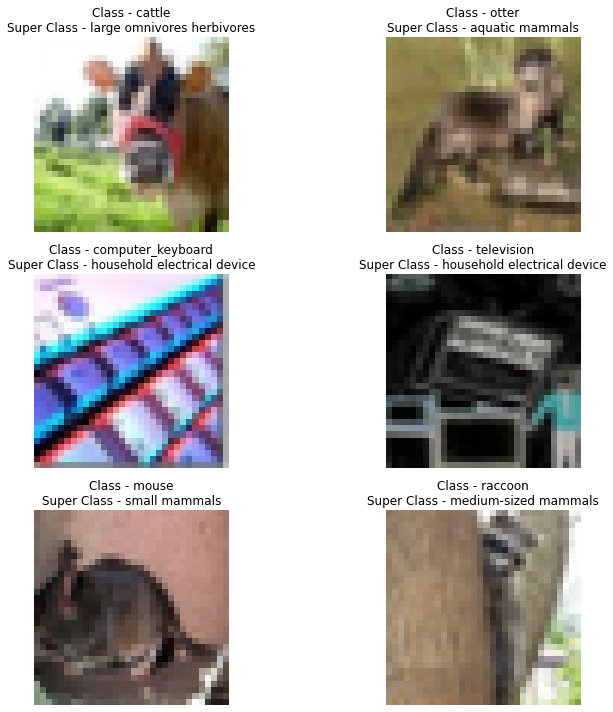

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

title: str = "Class - {0}\nSuper Class - {1}"
ax[0, 0].imshow(x_train[0])
ax[0, 0].set_title(title.format(classes[y_train[0][0]], 
                                super_classes[y_train[0][0]]))
ax[0, 0].axis("off")
ax[0, 1].imshow(x_train[100])
ax[0, 1].set_title(title.format(classes[y_train[100][0]], 
                                super_classes[y_train[100][0]]))
ax[0, 1].axis("off")
ax[1, 0].imshow(x_train[200])
ax[1, 0].set_title(title.format(classes[y_train[200][0]], 
                                super_classes[y_train[200][0]]))
ax[1, 0].axis("off")
ax[1, 1].imshow(x_train[600])
ax[1, 1].set_title(title.format(classes[y_train[600][0]], 
                                super_classes[y_train[600][0]]))
ax[1, 1].axis("off")
ax[2, 0].imshow(x_train[34000])
ax[2, 0].set_title(title.format(classes[y_train[34000][0]], 
                                super_classes[y_train[34000][0]]))
ax[2, 0].axis("off")
ax[2, 1].imshow(x_train[42001])
ax[2, 1].set_title(title.format(classes[y_train[42001][0]], 
                                super_classes[y_train[42001][0]]))
ax[2, 1].axis("off")
fig.tight_layout()
plt.show()

Let's look at the class balance:

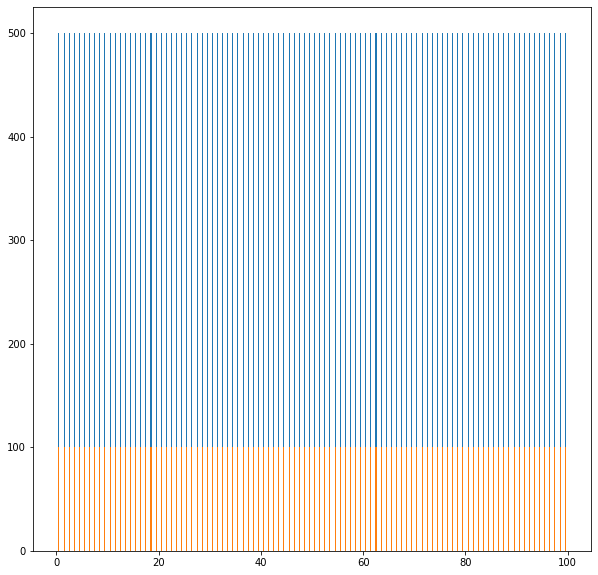

In [9]:
plt.figure(figsize=(10, 10))
plt.hist([x[0] for x in y_train], bins=100, rwidth=0.2, range=(0,100))
plt.hist([x[0] for x in y_test], bins=100, rwidth=0.2, range=(0,100))
plt.show()

We can see the test and train data is perfectly balanced.

### ***Fast text vectors***
Let's create a helper methods to transform string to vectors with our fast text vectors:

In [10]:
def text_to_avg_vector(sentence: str) -> np.ndarray:
    """
    Transform a string to a vector
    Parameters:
        sentence (str): string to transform to vector
        fast_text_vectors (Word2VecKeyedVectors): fast text vectors
    Returns:
        np.ndarray: vector representation of sentence
    """
    # create empty array
    vec: np.ndarray = np.array([0.0] * 300)
    # create word list of sentence
    word_list: List[str]  = text_to_word_sequence(sentence)

    for word in word_list:
        # add word vector to sentence vectors or zero if no word vector
        try:
          word_vec: np.ndarray = fast_text_vectors.word_vec(word)
          vec += word_vec
        except KeyError:
          vec += np.zeros(300)

    # return average vector (take sentence length into consideration)
    return vec / len(word_list)

Let's create a text vector for each of our classes and super classes:

In [11]:
tv_classes: np.ndarray = np.asarray(list(map(text_to_avg_vector, 
                                             classes)))
tv_super_classes: np.ndarray = np.asarray(list(map(text_to_avg_vector, 
                                                     super_classes)))
print(f"Classes vectors shape: {tv_classes.shape}")
print(f"Super classes vectors shape: {tv_super_classes.shape}")

Classes vectors shape: (100, 300)
Super classes vectors shape: (100, 300)


Let's create our new classes to predict. for each image instead of its class we want to predict its vectors making this a regression problem.
we will try 3 options:
1. vectors made only by class string.
2. vectors made only by super class string.
3. vectors made by combination of class and super class string.

In [12]:
y_train_class_vectors: np.ndarray = np.asarray([tv_classes[label] for 
                                                label in y_train])
y_train_class_vectors: np.ndarray = y_train_class_vectors.reshape((50000, 
                                                                   300))
y_test_class_vectors: np.ndarray = np.asarray([tv_classes[label] for 
                                               label in y_test])
y_test_class_vectors: np.ndarray = y_test_class_vectors.reshape((10000, 
                                                                 300))
print(f"Train class vectors shape: {y_train_class_vectors.shape}")
print(f"Test class vectors shape: {y_test_class_vectors.shape}")

Train class vectors shape: (50000, 300)
Test class vectors shape: (10000, 300)


In [13]:
y_train_super_class_vectors: np.ndarray = np.asarray(
    [tv_super_classes[label] for label in y_train])
y_train_super_class_vectors: np.ndarray =\
 y_train_super_class_vectors.reshape((50000, 300))
y_test_super_class_vectors: np.ndarray = np.asarray(
    [tv_super_classes[label] for label in y_test])
y_test_super_class_vectors: np.ndarray =\
 y_test_super_class_vectors.reshape((10000, 300))
print(f"Train super class vectors shape: {y_train_super_class_vectors.shape}")
print(f"Test super class vectors shape: {y_test_super_class_vectors.shape}")

Train super class vectors shape: (50000, 300)
Test super class vectors shape: (10000, 300)


In [14]:
y_train_combined_vectors: np.ndarray = y_train_class_vectors * 0.75 
y_train_combined_vectors += y_train_super_class_vectors * 0.25
y_test_combined_vectors: np.ndarray = y_test_class_vectors * 0.75 
y_test_combined_vectors += y_test_super_class_vectors * 0.25
print(f"Train combined class vectors shape: {y_train_combined_vectors.shape}")
print(f"Test combined class vectors shape: {y_test_combined_vectors.shape}")

Train combined class vectors shape: (50000, 300)
Test combined class vectors shape: (10000, 300)


Let's check the similarity  between each vector of class. This can help us understand which classes can be predicted wrongly because of their similarity.

In [15]:
# calculate cosine similarity between each two labels
similarity_matrix: np.ndarray = cosine_similarity(tv_classes, tv_classes)

# get only lower triangle 
similarity_matrix: np.ndarray = np.tril(similarity_matrix, -1)

# get only pairs with cosine similarity bigger than 0.6
indexes: np.ndarray = np.asarray(list(zip(*np.where(
    similarity_matrix > 0.6))))

# get the classes of each pairs
indexes_classes: np.ndarray = np.asarray(
    list(map(lambda x: (classes[x[0]], classes[x[1]]), indexes)))

print("The pairs with high cosine similarity (the classes):")
for i in indexes_classes:
  print(i)

The pairs with high cosine similarity (the classes):
['boy' 'baby']
['caterpillar' 'butterfly']
['couch' 'bed']
['dolphin' 'aquarium_fish']
['girl' 'baby']
['girl' 'boy']
['house' 'castle']
['lion' 'elephant']
['lion' 'leopard']
['lizard' 'dinosaur']
['lobster' 'crab']
['man' 'boy']
['man' 'girl']
['motorcycle' 'bicycle']
['mouse' 'hamster']
['mouse' 'computer_keyboard']
['oak_tree' 'forest']
['oak_tree' 'maple_tree']
['otter' 'beaver']
['palm_tree' 'maple_tree']
['palm_tree' 'oak_tree']
['pear' 'apple']
['pine_tree' 'forest']
['pine_tree' 'maple_tree']
['pine_tree' 'oak_tree']
['pine_tree' 'palm_tree']
['rabbit' 'fox']
['raccoon' 'beaver']
['shark' 'aquarium_fish']
['shark' 'crocodile']
['shark' 'dolphin']
['snake' 'crocodile']
['snake' 'lizard']
['spider' 'snake']
['squirrel' 'raccoon']
['tiger' 'crocodile']
['tiger' 'elephant']
['tiger' 'leopard']
['tiger' 'lion']
['tractor' 'lawn_mower']
['tractor' 'pickup_truck']
['turtle' 'dolphin']
['turtle' 'snake']
['whale' 'dolphin']
['whale'

It looks like we have a lot of classes that can be predicted wrongly, let's take a look at their super class

In [16]:
# get the super classes of each pairs
indexes_super_classes: np.ndarray = np.asarray(
    list(map(lambda x: (super_classes[x[0]], super_classes[x[1]]), 
             indexes)))
print("The pairs with high cosine similarity (the super classes):")
for i in indexes_classes:
  print(i)

The pairs with high cosine similarity (the super classes):
['boy' 'baby']
['caterpillar' 'butterfly']
['couch' 'bed']
['dolphin' 'aquarium_fish']
['girl' 'baby']
['girl' 'boy']
['house' 'castle']
['lion' 'elephant']
['lion' 'leopard']
['lizard' 'dinosaur']
['lobster' 'crab']
['man' 'boy']
['man' 'girl']
['motorcycle' 'bicycle']
['mouse' 'hamster']
['mouse' 'computer_keyboard']
['oak_tree' 'forest']
['oak_tree' 'maple_tree']
['otter' 'beaver']
['palm_tree' 'maple_tree']
['palm_tree' 'oak_tree']
['pear' 'apple']
['pine_tree' 'forest']
['pine_tree' 'maple_tree']
['pine_tree' 'oak_tree']
['pine_tree' 'palm_tree']
['rabbit' 'fox']
['raccoon' 'beaver']
['shark' 'aquarium_fish']
['shark' 'crocodile']
['shark' 'dolphin']
['snake' 'crocodile']
['snake' 'lizard']
['spider' 'snake']
['squirrel' 'raccoon']
['tiger' 'crocodile']
['tiger' 'elephant']
['tiger' 'leopard']
['tiger' 'lion']
['tractor' 'lawn_mower']
['tractor' 'pickup_truck']
['turtle' 'dolphin']
['turtle' 'snake']
['whale' 'dolphin']
['

We can see a lot of the pairs have the same super class so it's not a surprise if their similarity is high, let's look at only the pairs with different super classes:

In [17]:
# get the super classes of each pairs
filter_indexes: np.ndarray = np.asarray(
    list(filter(lambda x: super_classes[x[0]] != super_classes[x[1]], 
                indexes)))

indexes_classes: np.ndarray = np.asarray(
    list(map(lambda x: (classes[x[0]], classes[x[1]]), 
             filter_indexes)))

print("The pairs with high cosine similarity (the super classes):")
for i in indexes_classes:
  print(i)

The pairs with high cosine similarity (the super classes):
['dolphin' 'aquarium_fish']
['lion' 'elephant']
['mouse' 'computer_keyboard']
['oak_tree' 'forest']
['pine_tree' 'forest']
['rabbit' 'fox']
['raccoon' 'beaver']
['shark' 'crocodile']
['shark' 'dolphin']
['spider' 'snake']
['squirrel' 'raccoon']
['tiger' 'crocodile']
['tiger' 'elephant']
['tractor' 'pickup_truck']
['turtle' 'dolphin']
['whale' 'shark']
['wolf' 'fox']


These pairs have a high chance of being predicted wrongly.

## ***Model Training and Evaluation***

### ***Try One***

First we will try with prediction vectors made from class strings only.

#### ***Pre Process images***

In [18]:
x_train_preprocessed: np.ndarray = x_train.astype('float32')
x_test_preprocessed: np.ndarray = x_test.astype('float32')
x_train_preprocessed /= 255.0
x_test_preprocessed /= 255.0

#### ***Train Model***
Let's build a simple CNN model to predict our image vectors:

In [19]:
# Params for model
input_shape: Tuple = (32, 32, 3)
chan_dim: int = -1

#Create model
model = Sequential()

# Add CNN layers
#  Stack 1:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 2:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 3:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 4:
model.add(Flatten())
model.add(Dense(300))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer:
model.add(Dense(300))

# print model structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0

Next let's compile the model using MSE as our loss metric:

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

Now let's train the model:

In [21]:
history = model.fit(x_train, y_train_class_vectors, epochs=10, 
                    shuffle=True, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 13s 4ms/step - loss: 0.3696
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0125
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0133
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0131
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0123
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0115
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0111
Epoch 8/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0111
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0109
Epoch 10/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0110


Lets see our model performance:

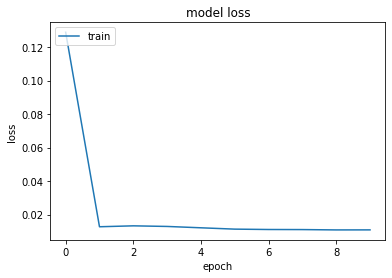

In [22]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### ***Test Model***

Let's evaluate our model on the test-set:

In [23]:
model_eval = model.evaluate(x_test, y_test_class_vectors) 
print(f"Model loss {model_eval}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0110
Model loss 0.011022607795894146


####  ***Predict Using Model***

Let's make some predictions using our model.

First let's create a method to predict the label:

In [24]:
def predict_label(img: np.ndarray) -> str:
  # predict query
  prediction: np.ndarray = model.predict([img])
  # get top-n by cosine similarity
  most_similar: List[str] = fast_text_vectors.similar_by_vector(prediction[0], topn=5)
  return ", ".join([x[0] for x in most_similar])

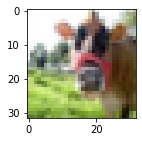

Actual class of image: cattle
Prediction for image: tiger, spider, snake, animal, rabbit


In [25]:
# display image
img: np.ndarray = x_train[0].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[0], axis=0))
print(f"Actual class of image: {classes[y_train[0][0]]}")
print(f"Prediction for image: {prediction}")

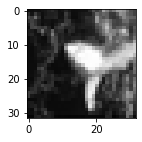

Actual class of image: shark
Prediction for image: monkey, mammal, raccoon, tiger, animal


In [26]:
# display image
img: np.ndarray = x_train[3000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[3000], axis=0))
print(f"Actual class of image: {classes[y_train[3000][0]]}")
print(f"Prediction for image: {prediction}")

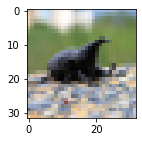

Actual class of image: beetle
Prediction for image: beetle, insect, turtle, spider, snake


In [27]:
# display image
img: np.ndarray = x_train[4000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[4000], axis=0))
print(f"Actual class of image: {classes[y_train[4000][0]]}")
print(f"Prediction for image: {prediction}")

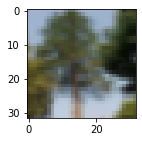

Actual class of image: pine_tree
Prediction for image: tree, trees, pine, oak, forest


In [28]:
# display image
img: np.ndarray = x_train[2000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[2000], axis=0))
print(f"Actual class of image: {classes[y_train[2000][0]]}")
print(f"Prediction for image: {prediction}")

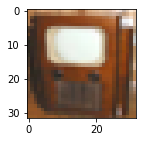

Actual class of image: television
Prediction for image: fish, tray, lady, lamp, girl


In [29]:
# display image
img: np.ndarray = x_train[1200].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[1200], axis=0))
print(f"Actual class of image: {classes[y_train[1200][0]]}")
print(f"Prediction for image: {prediction}")

### ***Try Two***

First we will try with prediction vectors made from super class string only.

#### ***Pre Process images***

In [30]:
x_train_preprocessed: np.ndarray = x_train.astype('float32')
x_test_preprocessed: np.ndarray = x_test.astype('float32')
x_train_preprocessed /= 255.0
x_test_preprocessed /= 255.0

#### ***Train Model***
Let's build a simple CNN model to predict our image vectors:

In [31]:
# Params for model
input_shape: Tuple = (32, 32, 3)
chan_dim: int = -1

#Create model
model = Sequential()

# Add CNN layers
#  Stack 1:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 2:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 3:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 4:
model.add(Flatten())
model.add(Dense(300))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer:
model.add(Dense(300))

# print model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 64)       

Next let's compile the model using MSE as our loss metric:

In [32]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

Now let's train the model:

In [33]:
history = model.fit(x_train, y_train_super_class_vectors, epochs=10, 
                    shuffle=True, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3171
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0059
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0064
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0064
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0059
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0053
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0048
Epoch 8/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0047
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0046
Epoch 10/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0044


Lets see our model performance:

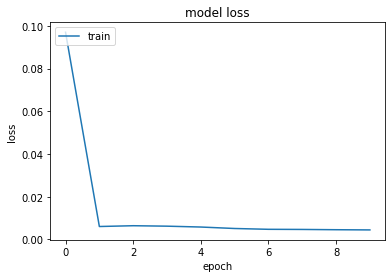

In [34]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### ***Test Model***

Let's evaluate our model on the test-set:

In [35]:
model_eval = model.evaluate(x_test, y_test_super_class_vectors) 
print(f"Model loss {model_eval}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0045
Model loss 0.004499251488596201


####  ***Predict Using Model***

Let's make some predictions using our model.

First let's create a method to predict the label:

In [36]:
def predict_label(img: np.ndarray) -> str:
  # predict query
  prediction: np.ndarray = model.predict([img])
  # get top-n by cosine similarity
  most_similar: List[str] = fast_text_vectors.similar_by_vector(prediction[0], topn=5)
  return ", ".join([x[0] for x in most_similar])

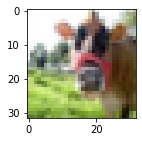

Actual class of image: cattle
Prediction for image: mammals, carnivores, animals, reptiles, insects


In [37]:
# display image
img: np.ndarray = x_train[0].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[0], axis=0))
print(f"Actual class of image: {classes[y_train[0][0]]}")
print(f"Prediction for image: {prediction}")

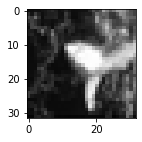

Actual class of image: shark
Prediction for image: mammals, reptiles, animals, vertebrates, fish


In [38]:
# display image
img: np.ndarray = x_train[3000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[3000], axis=0))
print(f"Actual class of image: {classes[y_train[3000][0]]}")
print(f"Prediction for image: {prediction}")

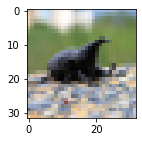

Actual class of image: beetle
Prediction for image: insects, mammals, reptiles, animals, trees


In [39]:
# display image
img: np.ndarray = x_train[4000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[4000], axis=0))
print(f"Actual class of image: {classes[y_train[4000][0]]}")
print(f"Prediction for image: {prediction}")

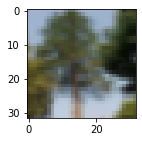

Actual class of image: pine_tree
Prediction for image: trees, shrubs, tree, forests, animals


In [40]:
# display image
img: np.ndarray = x_train[2000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[2000], axis=0))
print(f"Actual class of image: {classes[y_train[2000][0]]}")
print(f"Prediction for image: {prediction}")

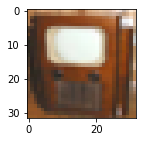

Actual class of image: television
Prediction for image: animals, reptiles, fish, vegetables, mammals


In [41]:
# display image
img: np.ndarray = x_train[1200].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[1200], axis=0))
print(f"Actual class of image: {classes[y_train[1200][0]]}")
print(f"Prediction for image: {prediction}")

### ***Try Three***

First we will try with prediction vectors made from class and super class string.

#### ***Pre Process images***

In [42]:
x_train_preprocessed: np.ndarray = x_train.astype('float32')
x_test_preprocessed: np.ndarray = x_test.astype('float32')
x_train_preprocessed /= 255.0
x_test_preprocessed /= 255.0

#### ***Train Model***
Let's build a simple CNN model to predict our image vectors:

In [43]:
# Params for model
input_shape: Tuple = (32, 32, 3)
chan_dim: int = -1

#Create model
model = Sequential()

# Add CNN layers
#  Stack 1:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 2:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 3:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stack 4:
model.add(Flatten())
model.add(Dense(300))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer:
model.add(Dense(300))

# print model structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 16, 16, 64)       

Next let's compile the model using MSE as our loss metric:

In [44]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

Now let's train the model:

In [45]:
history = model.fit(x_train, y_train_combined_vectors, epochs=10, 
                    shuffle=True, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3756
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0082
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0089
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0087
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0084
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0076
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0073
Epoch 8/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0071
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0070
Epoch 10/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0069


Lets see our model performance:

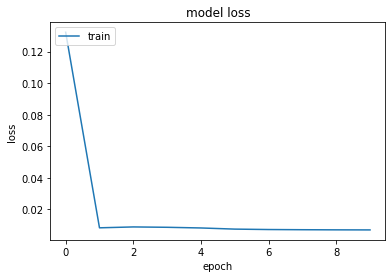

In [46]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### ***Test Model***

Let's evaluate our model on the test-set:

In [47]:
model_eval = model.evaluate(x_test, y_test_combined_vectors) 
print(f"Model loss {model_eval}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0069
Model loss 0.006859072018414736


####  ***Predict Using Model***

Let's make some predictions using our model.

First let's create a method to predict the label:

In [48]:
def predict_label(img: np.ndarray) -> str:
  # predict query
  prediction: np.ndarray = model.predict([img])
  # get top-n by cosine similarity
  most_similar: List[str] = fast_text_vectors.similar_by_vector(prediction[0], topn=5)
  return ", ".join([x[0] for x in most_similar])

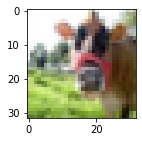

Actual class of image: cattle
Prediction for image: car, truck, house, animal, man


In [49]:
# display image
img: np.ndarray = x_train[0].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[0], axis=0))
print(f"Actual class of image: {classes[y_train[0][0]]}")
print(f"Prediction for image: {prediction}")

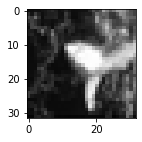

Actual class of image: shark
Prediction for image: fish, animal, mammal, creature, species


In [50]:
# display image
img: np.ndarray = x_train[3000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[3000], axis=0))
print(f"Actual class of image: {classes[y_train[3000][0]]}")
print(f"Prediction for image: {prediction}")

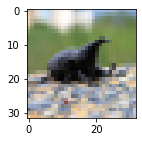

Actual class of image: beetle
Prediction for image: insect, insects, beetle, species, cockroach


In [51]:
# display image
img: np.ndarray = x_train[4000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[4000], axis=0))
print(f"Actual class of image: {classes[y_train[4000][0]]}")
print(f"Prediction for image: {prediction}")

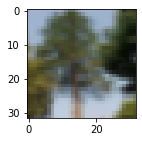

Actual class of image: pine_tree
Prediction for image: trees, tree, forest, pine, wood


In [52]:
# display image
img: np.ndarray = x_train[2000].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[2000], axis=0))
print(f"Actual class of image: {classes[y_train[2000][0]]}")
print(f"Prediction for image: {prediction}")

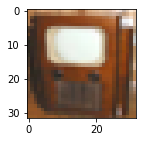

Actual class of image: television
Prediction for image: house, room, clothes, kitchen, car


In [53]:
# display image
img: np.ndarray = x_train[1200].copy()
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

# display prediction
prediction:str = predict_label(np.expand_dims(x_train[1200], axis=0))
print(f"Actual class of image: {classes[y_train[1200][0]]}")
print(f"Prediction for image: {prediction}")

## ***Conclusion***

As we can see in all the three models we tried the loss is low as expected from a regression problem. Some of the predictions are good and some are not accurate probably because of the similarity between vectors. To conclude we presented a model that is trained on cifar100 that can predict images with labels not in the dataset because of the use of fast text vectors.

Lest just save our model(we will save the combine class and super class):

In [54]:
model.save("image_classification_model.h5")